# 主に問2の後半を扱った部分です

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
%matplotlib inline


#推論にLightGbmを利用
import lightgbm as lgbm

In [8]:
# データの読み込み
from sklearn.datasets import fetch_covtype
data = fetch_covtype()

# データフレームの作成
df_data = pd.DataFrame(data.data, columns=data.feature_names)
df_target = pd.DataFrame(data.target)
df_target -= 1 #n値分類の場合は0~n-1のインデックスじゃないとエラーするので1引く

df_all = pd.concat([df_data, df_target],axis=1).rename(columns={0:'Cover_Type'})


df_all.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,1.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000


In [9]:
# 学習データ・テストデータ分割
# そのうち植生タイプが0/1のものはさらに分割

X_train,X_test,Y_train,Y_test = train_test_split(df_all, df_target, test_size = 0.2, stratify=df_target, random_state=1)

X_train_cov01 = X_train[X_train['Cover_Type']<2].drop('Cover_Type', axis=1)
X_train = X_train.drop('Cover_Type', axis=1)
X_test_cov01 = X_test[X_test['Cover_Type']<2].drop('Cover_Type', axis=1)
X_test = X_test.drop('Cover_Type', axis=1)

idx_train = X_train_cov01.index
idx_test = X_test_cov01.index
Y_train_cov01 = Y_train.loc[idx_train]
Y_test_cov01 = Y_test.loc[idx_test]


print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

print(X_test_cov01.shape, Y_test_cov01.shape)
print(X_test_cov01.shape, Y_test_cov01.shape)


(464809, 54) (464809, 1)
(116203, 54) (116203, 1)
(99029, 54) (99029, 1)
(99029, 54) (99029, 1)


In [5]:
X_test_cov01

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
503633,3041.0,62.0,28.0,175.0,45.0,1045.0,231.0,172.0,55.0,1749.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39808,3050.0,92.0,22.0,417.0,183.0,6308.0,247.0,201.0,72.0,3918.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82814,2615.0,11.0,8.0,256.0,63.0,902.0,212.0,224.0,150.0,663.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134360,3014.0,27.0,14.0,60.0,-9.0,3586.0,213.0,209.0,129.0,2683.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
346902,2924.0,59.0,13.0,175.0,40.0,1729.0,230.0,211.0,112.0,2684.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94237,3027.0,76.0,15.0,418.0,26.0,3767.0,237.0,211.0,101.0,4800.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397640,2795.0,257.0,18.0,270.0,70.0,2542.0,175.0,248.0,210.0,67.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
392438,3180.0,270.0,8.0,540.0,83.0,927.0,200.0,243.0,182.0,849.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173896,3193.0,110.0,9.0,210.0,2.0,5455.0,236.0,230.0,126.0,3092.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' cal

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2269
[LightGBM] [Info] Number of data points in the train set: 371847, number of used features: 53
[LightGBM] [Info] Start training from score -1.008943
[LightGBM] [Info] Start training from score -0.718263
[LightGBM] [Info] Start training from score -2.788088
[LightGBM] [Info] Start training from score -5.353737
[LightGBM] [Info] Start training from score -4.114300
[LightGBM] [Info] Start training from score -3.510187
[LightGBM] [Info] Start training from score -3.343887
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.39111	valid's multi_logloss: 0.406068
[200]	train's multi_logloss: 0.324413	valid's multi_logloss: 0.346437
[300]	train's multi_logloss: 0.284716	valid's multi_logloss: 0.31

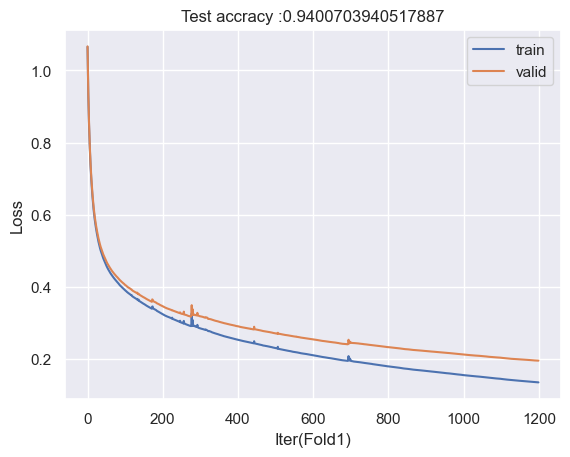

None

/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' cal

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2264
[LightGBM] [Info] Number of data points in the train set: 371847, number of used features: 53
[LightGBM] [Info] Start training from score -1.008943
[LightGBM] [Info] Start training from score -0.718263
[LightGBM] [Info] Start training from score -2.788088
[LightGBM] [Info] Start training from score -5.353737
[LightGBM] [Info] Start training from score -4.114300
[LightGBM] [Info] Start training from score -3.510187
[LightGBM] [Info] Start training from score -3.343887
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.392795	valid's multi_logloss: 0.404904
[200]	train's multi_logloss: 0.324641	valid's multi_logloss: 0.34284
[300]	train's multi_logloss: 0.287125	valid's multi_logloss: 0.30

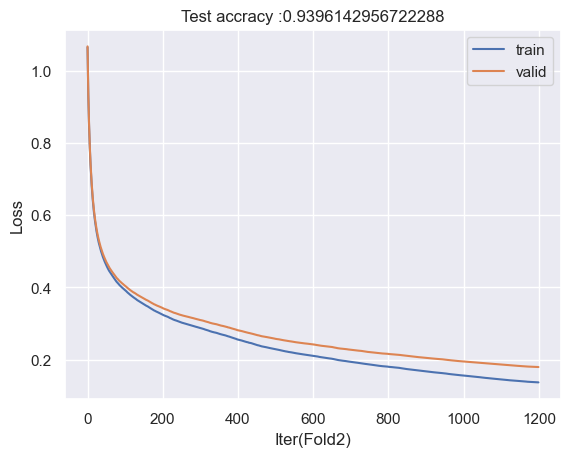

None

/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' cal

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2266
[LightGBM] [Info] Number of data points in the train set: 371847, number of used features: 53
[LightGBM] [Info] Start training from score -1.008935
[LightGBM] [Info] Start training from score -0.718263
[LightGBM] [Info] Start training from score -2.788132
[LightGBM] [Info] Start training from score -5.354306
[LightGBM] [Info] Start training from score -4.114300
[LightGBM] [Info] Start training from score -3.510097
[LightGBM] [Info] Start training from score -3.343887
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.389225	valid's multi_logloss: 0.404467
[200]	train's multi_logloss: 0.319237	valid's multi_logloss: 0.339844
[300]	train's multi_logloss: 0.277824	valid's multi_logloss: 0.302704
[400]	train's multi_logloss: 0.249581	valid's multi_loglos

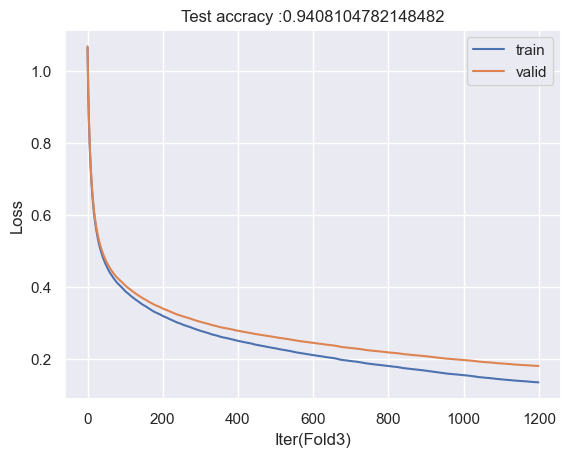

None

/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' cal

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 371847, number of used features: 53
[LightGBM] [Info] Start training from score -1.008935
[LightGBM] [Info] Start training from score -0.718263
[LightGBM] [Info] Start training from score -2.788132
[LightGBM] [Info] Start training from score -5.354306
[LightGBM] [Info] Start training from score -4.114300
[LightGBM] [Info] Start training from score -3.510187
[LightGBM] [Info] Start training from score -3.343811
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.392426	valid's multi_logloss: 0.406732
[200]	train's multi_logloss: 0.322254	valid's multi_logloss: 0.341621
[300]	train's multi_logloss: 0.279935	valid's multi_logloss: 0.3

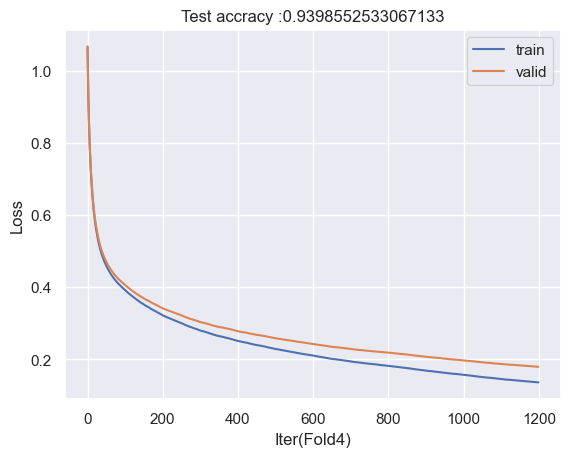

None

/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' cal

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2263
[LightGBM] [Info] Number of data points in the train set: 371848, number of used features: 53
[LightGBM] [Info] Start training from score -1.008938
[LightGBM] [Info] Start training from score -0.718266
[LightGBM] [Info] Start training from score -2.788135
[LightGBM] [Info] Start training from score -5.354308
[LightGBM] [Info] Start training from score -4.114139
[LightGBM] [Info] Start training from score -3.510190
[LightGBM] [Info] Start training from score -3.343814
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.389256	valid's multi_logloss: 0.401417
[200]	train's multi_logloss: 0.320173	valid's multi_logloss: 0.338007
[300]	train's multi_logloss: 0.28164	valid's multi_logloss: 0.30

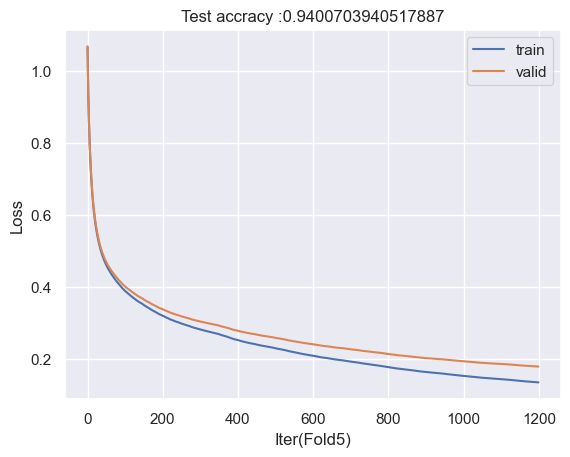

None

In [10]:
#全データで学習するモデル

# model格納用
models = []

# 学習データの数だけの数列（0行から最終行まで連番）
row_num = list(range(len(Y_train)))

# 5分割で交差検証
K_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# パラメータ
params = {'task': 'train',               
          'boosting_type': 'gbdt',    
          'objective': 'multiclass',    
          'metric': 'multi_logloss',    
          'num_class': 7,               
          'learning_rate': 0.06,         
          'num_leaves': 30,           
          'min_data_in_leaf': 15,          
         }


# 学習（5分割）
fold = 0
for train_idx, eval_idx in K_fold.split(row_num, Y_train):
    fold += 1

    # 交差検証用データの引き出し
    X_train_cv = X_train.iloc[train_idx, :]
    y_train_cv = Y_train.iloc[train_idx]
    X_eval_cv = X_train.iloc[eval_idx, :]
    y_eval_cv = Y_train.iloc[eval_idx]
    
    # 学習・検証データセット
    train_set = lgbm.Dataset(X_train_cv, y_train_cv)
    eval_set = lgbm.Dataset(X_eval_cv, y_eval_cv, reference=train_set)

    # 学習
    evaluation_results = {}                  
    model = lgbm.train(params,                                
                      train_set,                             
                      num_boost_round=1200,                  
                      valid_names=['train', 'valid'],         
                      valid_sets=[train_set, eval_set],        
                      evals_result=evaluation_results,        
                      early_stopping_rounds=50,                 
                      verbose_eval=100)                          
    
    # テスト
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred_max = np.argmax(y_pred, axis=1)

    acc = sum(Y_test.values.reshape(-1) == y_pred_max) / len(Y_test)
    print('Testdata accuracy:', acc)

    # ロスの可視化
    sns.set()
    plt.plot(evaluation_results['train']['multi_logloss'], label='train')
    plt.plot(evaluation_results['valid']['multi_logloss'], label='valid')
    plt.ylabel('Loss')
    plt.xlabel('Iter(Fold{})'.format(fold))
    plt.legend()
    plt.title('Test accracy :{}'.format(acc))
    display(plt.show())
    
    models.append(model) 

/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' cal

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2250
[LightGBM] [Info] Number of data points in the train set: 316889, number of used features: 49
[LightGBM] [Info] Start training from score -0.849012
[LightGBM] [Info] Start training from score -0.558332
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.313235	valid's multi_logloss: 0.320777
[200]	train's multi_logloss: 0.264691	valid's multi_logloss: 0.274677
[300]	train's multi_logloss: 0.236911	valid's multi_logloss: 0.248707
[400]	train's multi_logloss: 0.2133	valid's multi_logloss: 0.226743
[500]	train's multi_logloss: 0.192027	valid's multi_logloss: 0.207277
[600]	train's multi_logloss: 0.176475	valid's multi_logloss: 0.193479
[700]	train's multi_logloss: 0.163376	valid's multi_logl

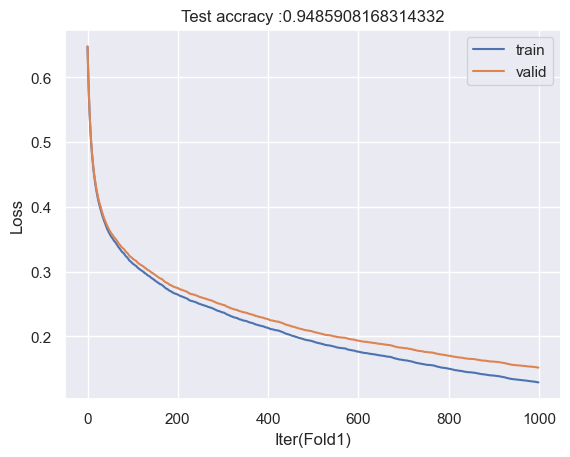

None

/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' cal

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2251
[LightGBM] [Info] Number of data points in the train set: 316889, number of used features: 49
[LightGBM] [Info] Start training from score -0.849012
[LightGBM] [Info] Start training from score -0.558332
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.313005	valid's multi_logloss: 0.319062
[200]	train's multi_logloss: 0.267874	valid's multi_logloss: 0.277327
[300]	train's multi_logloss: 0.238894	valid's multi_logloss: 0.25083
[400]	train's multi_logloss: 0.207881	valid's multi_logloss: 0.221706
[500]	train's multi_logloss: 0.189665	valid's multi_logloss: 0.205453
[600]	train's multi_logloss: 0.173655	valid's multi_logloss: 0.191515
[700]	train's multi_logloss: 0.160947	valid's multi_log

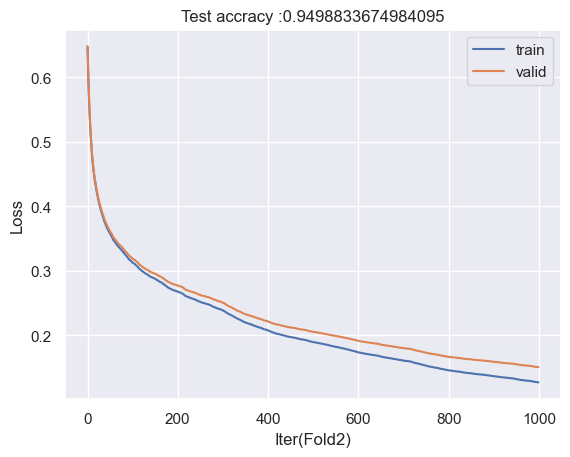

None

/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' cal

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2244
[LightGBM] [Info] Number of data points in the train set: 316890, number of used features: 49
[LightGBM] [Info] Start training from score -0.849008
[LightGBM] [Info] Start training from score -0.558335
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.315571	valid's multi_logloss: 0.319713
[200]	train's multi_logloss: 0.267446	valid's multi_logloss: 0.275649
[300]	train's multi_logloss: 0.23321	valid's multi_logloss: 0.243509
[400]	train's multi_logloss: 0.208399	valid's multi_logloss: 0.221021
[500]	train's multi_logloss: 0.187944	valid's multi_logloss: 0.202601
[600]	train's multi_logloss: 0.170425	valid's multi_logloss: 0.187264
[700]	train's multi_logloss: 0.154661	valid's multi_log

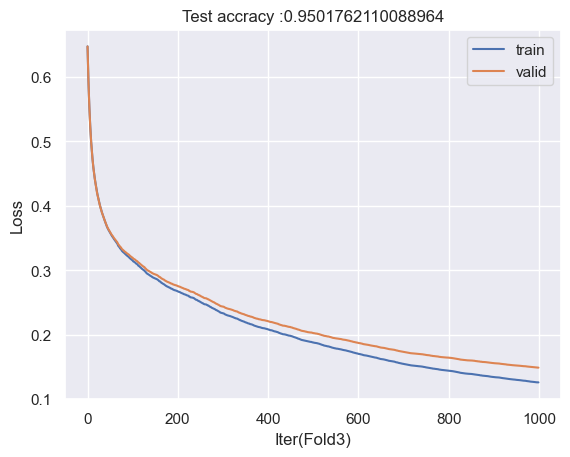

None

/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' cal

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2253
[LightGBM] [Info] Number of data points in the train set: 316890, number of used features: 49
[LightGBM] [Info] Start training from score -0.849008
[LightGBM] [Info] Start training from score -0.558335
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.315356	valid's multi_logloss: 0.321094
[200]	train's multi_logloss: 0.271013	valid's multi_logloss: 0.279508
[300]	train's multi_logloss: 0.236414	valid's multi_logloss: 0.247347
[400]	train's multi_logloss: 0.209873	valid's multi_logloss: 0.223155
[500]	train's multi_logloss: 0.190395	valid's multi_logloss: 0.206037
[600]	train's multi_logloss: 0.173562	valid's multi_logloss: 0.191253
[700]	train's multi_logloss: 0.159061	valid's multi_lo

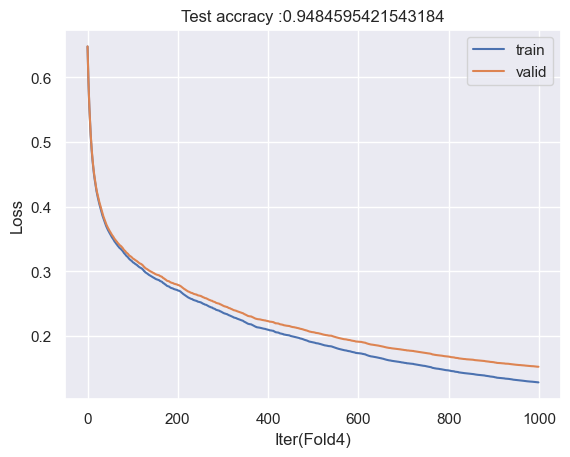

None

/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/sawaki/opt/anaconda3/envs/murata_lab/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' cal

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 316890, number of used features: 49
[LightGBM] [Info] Start training from score -0.849008
[LightGBM] [Info] Start training from score -0.558335
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.315822	valid's multi_logloss: 0.320908
[200]	train's multi_logloss: 0.266044	valid's multi_logloss: 0.274456
[300]	train's multi_logloss: 0.228059	valid's multi_logloss: 0.239267
[400]	train's multi_logloss: 0.203976	valid's multi_logloss: 0.217492
[500]	train's multi_logloss: 0.185717	valid's multi_logloss: 0.201444
[600]	train's multi_logloss: 0.168427	valid's multi_logloss: 0.185922
[700]	train's multi_logloss: 0.15718	valid's multi_log

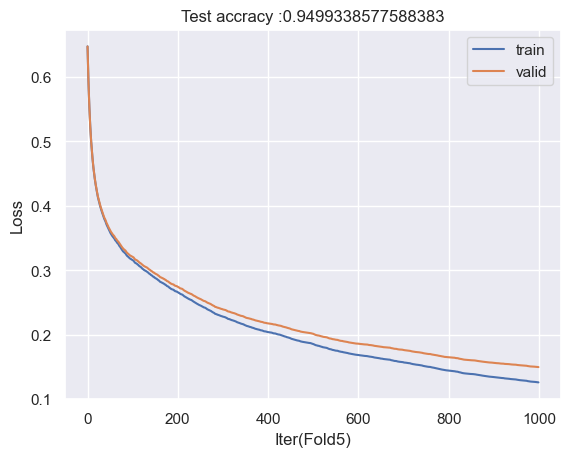

None

In [11]:
# CoverType 0/1 だけを学習するモデル

# model格納用
models_cov01 = []

# 学習データの数だけの数列（0行から最終行まで連番）
row_num = list(range(len(Y_train_cov01)))

# 4分割で交差検証
K_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# パラメータ
params = {'task': 'train',               
          'boosting_type': 'gbdt',    
          'objective': 'multiclass',    
          'metric': 'multi_logloss',    
          'num_class': 2,               
          'learning_rate': 0.1,         
          'num_leaves': 40,           
          'min_data_in_leaf': 10,          
         }


# 学習（5分割）
fold = 0
for train_idx, eval_idx in K_fold.split(row_num, Y_train_cov01):
    fold += 1

    # 交差検証用データの引き出し
    X_train_cv = X_train_cov01.iloc[train_idx, :]
    y_train_cv = Y_train_cov01.iloc[train_idx]
    X_eval_cv = X_train_cov01.iloc[eval_idx, :]
    y_eval_cv = Y_train_cov01.iloc[eval_idx]
    
    # 学習・検証データセット
    train_set = lgbm.Dataset(X_train_cv, y_train_cv)
    eval_set = lgbm.Dataset(X_eval_cv, y_eval_cv, reference=train_set)

    # 学習
    evaluation_results = {}                  
    model = lgbm.train(params,                                
                      train_set,                             
                      num_boost_round=1000,                  
                      valid_names=['train', 'valid'],         
                      valid_sets=[train_set, eval_set],        
                      evals_result=evaluation_results,        
                      early_stopping_rounds=50,                 
                      verbose_eval=100)                          
    
    # テスト
    y_pred_cov01 = model.predict(X_test_cov01, num_iteration=model.best_iteration)
    y_pred_cov01_max = np.argmax(y_pred_cov01, axis=1)

    #print(Y_test_cov01.values.shape, y_pred_cov01_max.shape, Y_test_cov01.shape)
    acc = sum(Y_test_cov01.values.reshape(-1) == y_pred_cov01_max) / len(Y_test_cov01)
    print('Testdata accuracy:', acc)
    
    # ロスの可視化
    sns.set()
    plt.plot(evaluation_results['train']['multi_logloss'], label='train')
    plt.plot(evaluation_results['valid']['multi_logloss'], label='valid')
    plt.ylabel('Loss')
    plt.xlabel('Iter(Fold{})'.format(fold))
    plt.legend()
    plt.title('Test accracy :{}'.format(acc))
    display(plt.show())

    models_cov01.append(model) 

In [12]:
# テスト
y_pred = np.zeros([len(X_test),7])
print(y_pred.shape)
for i in range(len(models)):
    y_pred += models[i].predict(X_test, num_iteration=model.best_iteration)
    print('model', i)
y_pred = y_pred/5



y_pred_max = np.argmax(y_pred, axis=1)
# 正解率
acc = sum(Y_test.values.reshape(-1) == y_pred_max) / len(Y_test)
print('accuracy:', acc)


(116203, 7)
model 0
model 1
model 2
model 3
model 4
accuracy: 0.93722193058699


In [13]:
# 0/1二値学習モデルで再テストするデータを選択する

df_pred = pd.DataFrame(y_pred)
df_correct = pd.DataFrame(Y_test).reset_index().rename(columns={0:'Correct', 'index':'original index'})
df_pred = pd.concat([df_pred, df_correct],axis=1).drop('Correct', axis=1)

# Cov_Type0/1の推測値が共に0.1を上回る場合は0/1二値学習モデルで再チェック
df_confusing01 = df_pred[(df_pred[0] > 0.1) & (df_pred[1] > 0.1)]
df_others = df_pred[~((df_pred[0] > 0.1) & (df_pred[1] > 0.1))]

idx_recheck = df_confusing01['original index'].values
idx_others = df_others['original index'].values

# 再テストデータ
Y_test_recheck = Y_test.loc[idx_recheck]
X_test_recheck = X_test.loc[idx_recheck] 

Y_test_others = Y_test.loc[idx_others]


In [14]:
# 二値学習モデルで再テスト
y_pred_recheck = np.zeros([len(X_test_recheck),2])

for i in range(len(models_cov01)):
    y_pred_recheck += models_cov01[i].predict(X_test_recheck, num_iteration=model.best_iteration)
    print('model',i)

y_pred_recheck = y_pred_recheck/len(models_cov01)

df_pred_recheck = pd.DataFrame(y_pred_recheck)
df_correct_recheck = pd.DataFrame(Y_test_recheck).reset_index().rename(columns={0:'Correct', 'index':'original index'})
df_pred_recheck = pd.concat([df_pred_recheck, df_correct_recheck],axis=1).drop('Correct', axis=1)

df_pred_recheck

model 0
model 1
model 2
model 3
model 4


,0,1,original index
0,0.877021,0.122979,134360
1,0.114080,0.885920,346902
2,0.103083,0.896917,156694
3,0.203464,0.796536,267401
4,0.650666,0.349334,490062
...,...,...,...
37861,0.540129,0.459871,439373
37862,0.110590,0.889410,94237
37863,0.192644,0.807356,397640
37864,0.149733,0.850267,392438


In [15]:
# そもそも再テストデータにCov_Type2~6が含まれていてもおかしくない
Y_test_recheck.value_counts()

1    19541
0    18147
4      126
6       31
5       16
2        5
Name: count, dtype: int64

In [16]:
# 再チェック以外のデータの正解率
y_pred_others = df_others.drop(columns='original index').values

y_pred_others_max = np.argmax(y_pred_others, axis=1)
acc_others = sum(Y_test_others.values.reshape(-1) == y_pred_others_max) / len(Y_test_others)
print('accuracy:', acc_others)
#print(Y_test_others.values.reshape(-1).shape,  y_pred_others_max.shape, Y_test_others.shape)
print(sum(Y_test_others.values.reshape(-1) == y_pred_others_max), len(Y_test_others))

accuracy: 0.9825752837101243
76972 78337


In [17]:
# 再チェックの正解率
y_pred_recheck_max = np.argmax(y_pred_recheck, axis=1)
acc_recheck = sum(Y_test_recheck.values.reshape(-1) == y_pred_recheck_max) / len(Y_test_recheck)
print('accuracy:', acc_recheck)
#print(Y_test_recheck.values.reshape(-1).shape,  y_pred_recheck_max.shape, Y_test_recheck.shape)
print(sum(Y_test_recheck.values.reshape(-1) == y_pred_recheck_max), len(Y_test_recheck))


accuracy: 0.8757460518671103
33161 37866


In [18]:
# 総合正解率
acc_total = (sum(Y_test_others.values.reshape(-1) == y_pred_others_max)+sum(Y_test_recheck.values.reshape(-1) == y_pred_recheck_max)) / len(Y_test)
print('accracy', acc_total)
print(sum(Y_test_others.values.reshape(-1) == y_pred_others_max)+sum(Y_test_recheck.values.reshape(-1) == y_pred_recheck_max), len(Y_test))

accracy 0.947763827095686
110133 116203


,0,1,2,3,4,5,6
0,0,1762,3,0,36,5,8
1,2765,0,2,0,90,11,23
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0


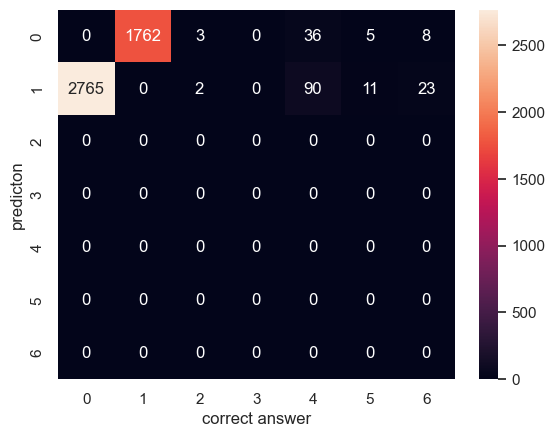

In [19]:
# 予測データの推測確率と正誤リスト

df_pred_recheck = pd.DataFrame(y_pred)
df_pred_recheck_max = pd.DataFrame(y_pred_recheck_max).rename(columns={0:'pred'})
df_correct_recheck = pd.DataFrame(Y_test_recheck).reset_index().rename(columns={0:'Correct', 'index':'original index'})
tf = pd.DataFrame(Y_test_recheck.values.reshape(-1) == y_pred_recheck_max).rename(columns={0:'T/F'})


df_pred_recheck_TF = pd.concat([df_pred_recheck, df_correct_recheck],axis=1)
df_pred_recheck_TF = pd.concat([df_pred_recheck_TF, df_pred_recheck_max],axis=1)
df_pred_recheck_TF = pd.concat([df_pred_recheck_TF, tf],axis=1)

df_pred_recheck_F = df_pred_recheck_TF[df_pred_recheck_TF['T/F'] == False]
df_pred_recheck_T = df_pred_recheck_TF[df_pred_recheck_TF['T/F'] == True]

df_pred_recheck_TF

# 何と何を間違えたのか？

df_pred_recheck_F[['Correct','pred']]

TF_recheck_mat = np.zeros([7,7])
for i in range(7):
    df = df_pred_recheck_F[df_pred_recheck_F['pred'] == i]
    for j in range(7):
        TF_recheck_mat[i,j]=(len(df[df['Correct'] == j]))

display(pd.DataFrame(TF_recheck_mat).astype(int))
sns.heatmap(pd.DataFrame(TF_recheck_mat).astype(int), annot=True, fmt='d')
plt.xlabel("correct answer")
plt.ylabel("predicton")
plt.show()